In [255]:
import numpy as np
import seaborn as sns
import transformation
import significantdigits as sd
from collections import Counter
from matplotlib import pyplot as plt
from fsl.transform import flirt, affine

import warnings
warnings.filterwarnings('ignore')

In [256]:
#remove all the numbers later 50, 10, 3 etc

In [257]:
# path_PD = './outputs_PD/anat-12dofs'
# path_HC = './outputs_HC/anat-12dofs'

path_PD = './pipline/pd/outputs/anat-12dofs'
path_HC = './pipline/hc/outputs/anat-12dofs'

In [258]:
paths_PD = transformation.get_matrices_paths(path_PD)
paths_HC = transformation.get_matrices_paths(path_HC)

In [259]:
mat_dic_PD = transformation.get_matrices(paths_PD)
mat_dic_HC = transformation.get_matrices(paths_HC)

In [260]:
mean_PD, std_PD = np.zeros((50,4,4)), np.zeros((50,4,4))
mean_HC, std_HC = np.zeros((50,4,4)), np.zeros((50,4,4))

for i,sub in enumerate(mat_dic_PD.keys()):
    mean_PD[i] = np.mean(mat_dic_PD[sub]["mca"], axis=0)
    std_PD[i] = np.std(mat_dic_PD[sub]["mca"], axis=0)

for i,sub in enumerate(mat_dic_HC.keys()):
    mean_HC[i] = np.mean(mat_dic_HC[sub]['mca'], axis=0)
    std_HC[i] = np.std(mat_dic_HC[sub]["mca"], axis=0)


In [263]:
def cell_significant_digit(mat_dic):

    significant_digits_dict = {key:np.zeros((4,4)) for key in mat_dic.keys()}
    for key in mat_dic.keys():
        matrix = mat_dic[key]['mca']
        mean_sub = np.mean(matrix, axis=0)
        for i in range(4):
            for j in range(4):
                significant_digits_dict[key][i,j] = sd.significant_digits(matrix[:,i,j], reference=mean_sub[i,j], basis=10)
    
    return significant_digits_dict

In [264]:
cell_significant_digits_dict_PD = cell_significant_digit(mat_dic_PD)
cell_significant_digits_dict_HC = cell_significant_digit(mat_dic_HC)

In [265]:
cell_significant_digits_PD = np.array(list(cell_significant_digits_dict_PD.values()))
cell_significant_digits_HC = np.array(list(cell_significant_digits_dict_HC.values()))

In [266]:
np.max(cell_significant_digits_PD, axis=0)

array([[ 4.36322389,  2.41325873,  3.65072848,  3.18710843],
       [ 3.35817041,  3.95227435,  2.87620335,  3.37230713],
       [ 2.70499451,  3.30505676,  3.74174087,  3.00172415],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [267]:
np.max(cell_significant_digits_HC, axis=0)

array([[ 4.07742919,  2.41462272,  1.93317697,  2.36443501],
       [ 2.58063545,  3.93672643,  2.95242996,  2.71478049],
       [ 2.66081698,  3.33450377,  3.64529522,  2.641961  ],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [268]:
np.mean(cell_significant_digits_PD, axis=0)

array([[ 3.24552485,  1.2329296 ,  1.24346026,  1.64923142],
       [ 1.53417493,  3.20050041,  2.14506234,  2.16171789],
       [ 1.41555066,  2.75271937,  2.90599629,  2.02360553],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [269]:
np.mean(cell_significant_digits_HC, axis=0)

array([[ 3.25374615,  1.26200326,  1.10144623,  1.55383773],
       [ 1.65461715,  3.17086336,  2.17155632,  2.00848687],
       [ 1.40592752,  2.63179251,  3.02811607,  1.9289024 ],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [270]:
np.min(cell_significant_digits_PD, axis=0)

array([[ 1.2324824 , -0.47019661, -1.07024868,  0.21430974],
       [-1.01781593,  1.38690681,  0.84995407,  0.91060458],
       [-0.26617758,  0.93321072, -0.3553351 ,  0.37088834],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [271]:
np.min(cell_significant_digits_HC, axis=0)

array([[ 2.83107158, -0.55504235, -0.43240611,  0.23702599],
       [ 0.08259193,  2.37841215,  0.47138719,  0.19896421],
       [-0.51524834,  1.02471279,  2.03632779,  0.26977358],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

Text(0.5, 1.0, 'MCA means for each cell _PD subjects_')

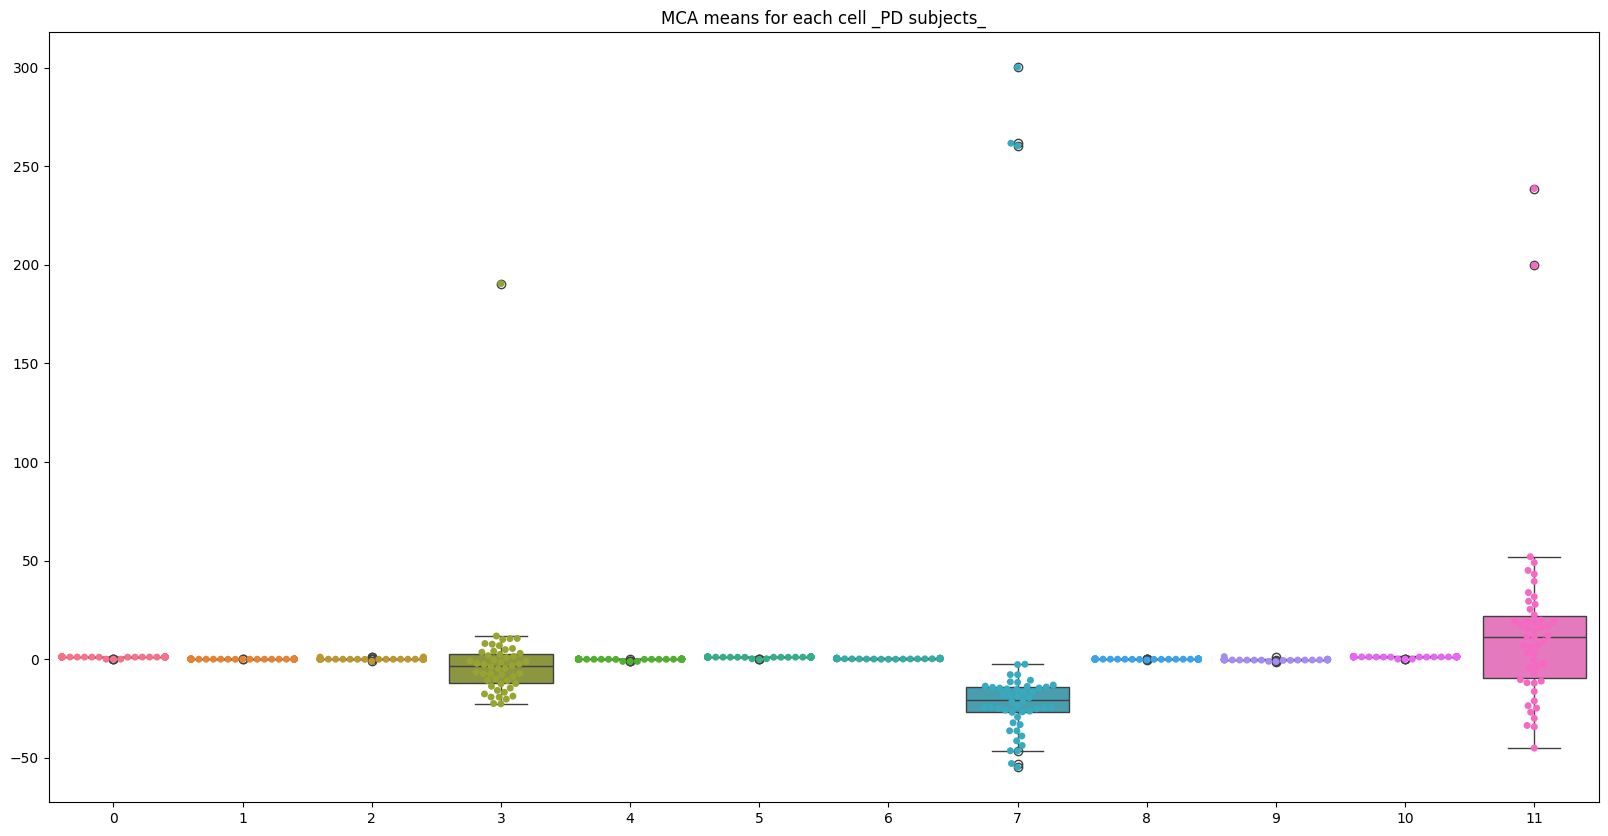

In [272]:
plt.figure(figsize=(20,10))
_ = sns.swarmplot(mean_PD[:,:3,:].reshape(50,12))
_ = sns.boxplot(mean_PD[:,:3,:].reshape(50,12))
plt.title('MCA means for each cell _PD subjects_')

Text(0.5, 1.0, 'MCA SD for each cell _PD subjects_')

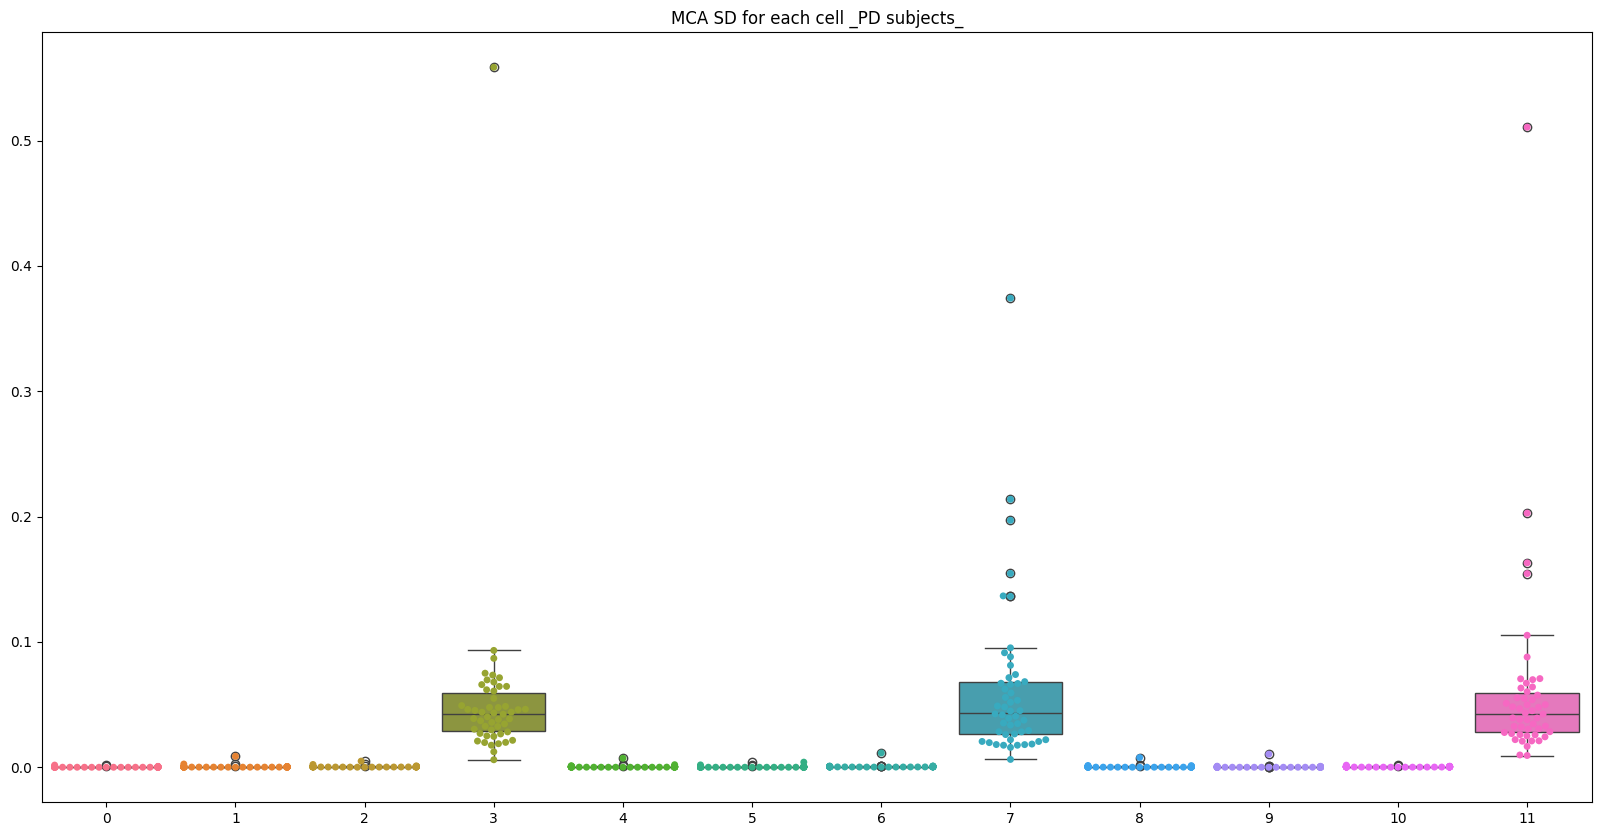

In [273]:
plt.figure(figsize=(20,10))
_ = sns.swarmplot(std_PD[:,:3,:].reshape(50,12))
_ = sns.boxplot(std_PD[:,:3,:].reshape(50,12))
plt.title('MCA SD for each cell _PD subjects_')

Text(0.5, 1.0, 'MCA means for each cell _HC subjects_')

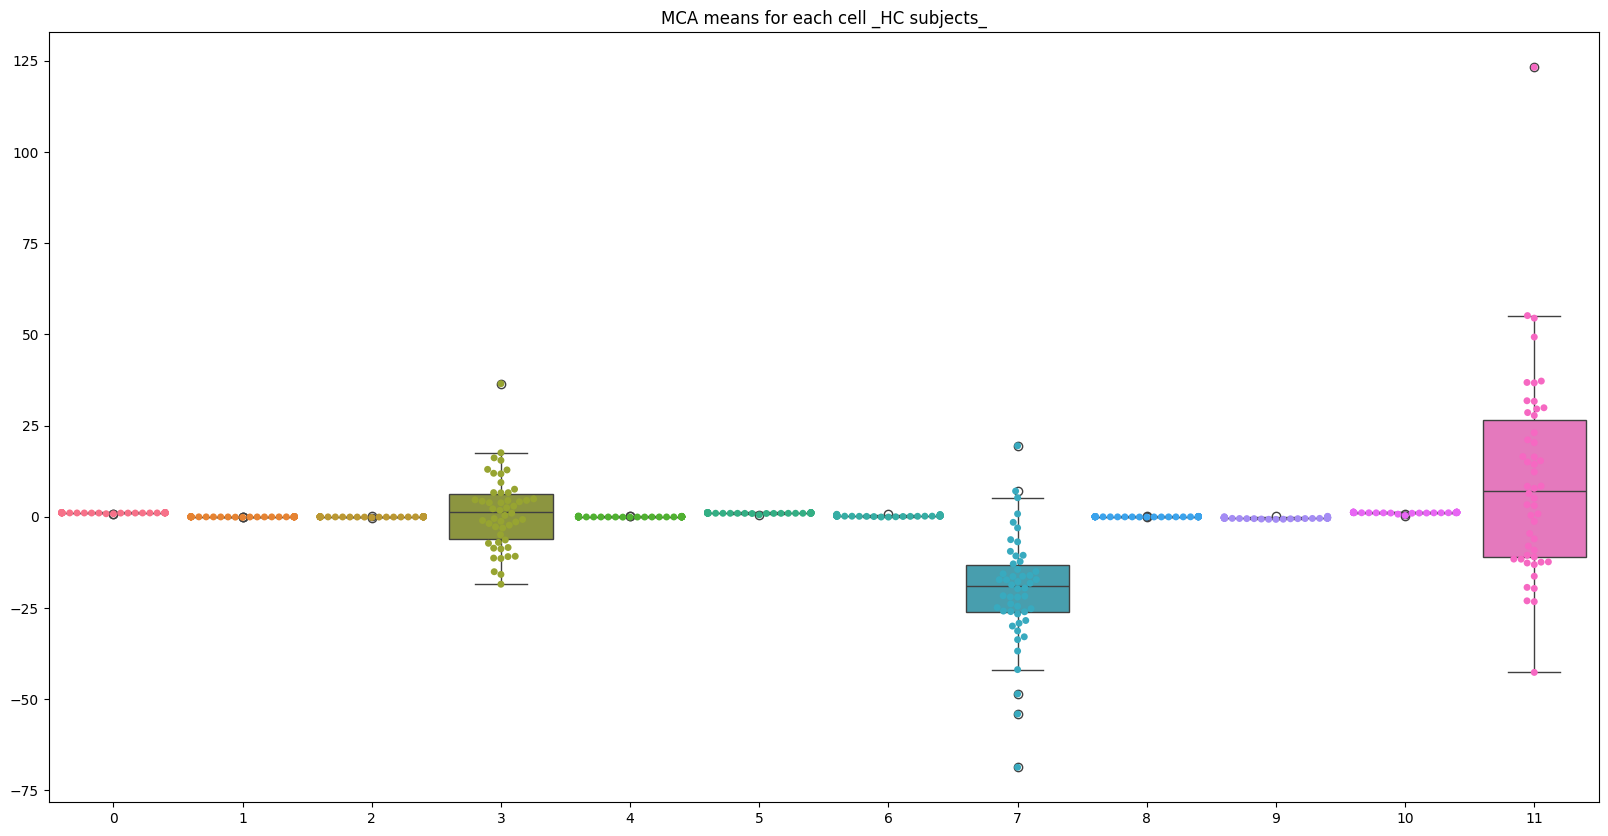

In [274]:
plt.figure(figsize=(20,10))
sns.swarmplot(mean_HC[:,:3,:].reshape(50,12))
sns.boxplot(mean_HC[:,:3,:].reshape(50,12))
plt.title('MCA means for each cell _HC subjects_')

Text(0.5, 1.0, 'MCA sds for each cell _HC subjects_')

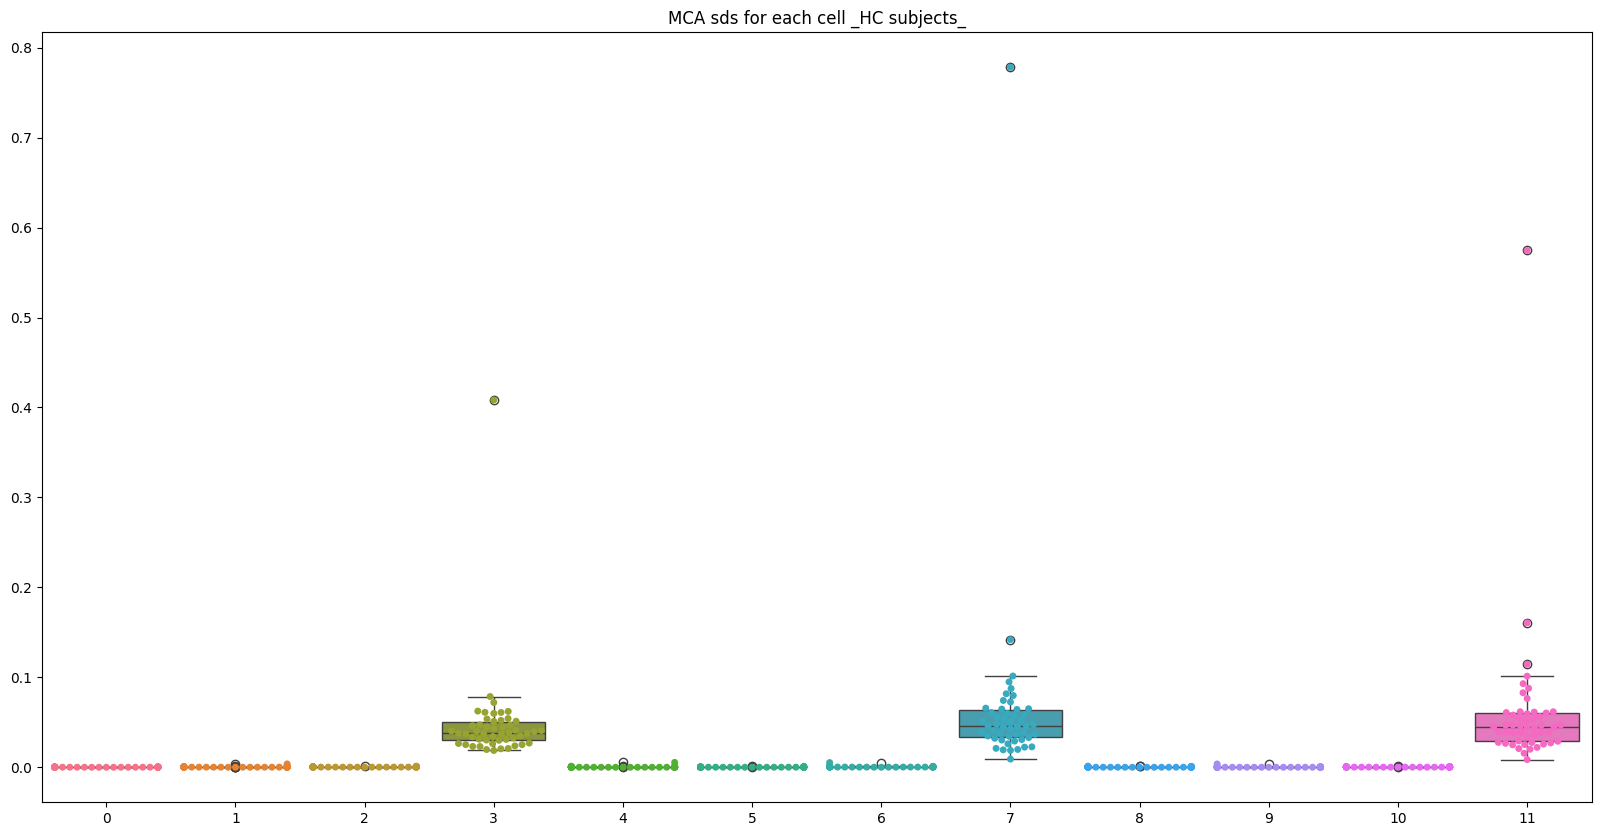

In [275]:
plt.figure(figsize=(20,10))
sns.swarmplot(std_HC[:,:3,:].reshape(50,12))
sns.boxplot(std_HC[:,:3,:].reshape(50,12))
plt.title('MCA sds for each cell _HC subjects_')

Text(0.5, 1.0, 'Significant digits for each cell _PD subjects_')

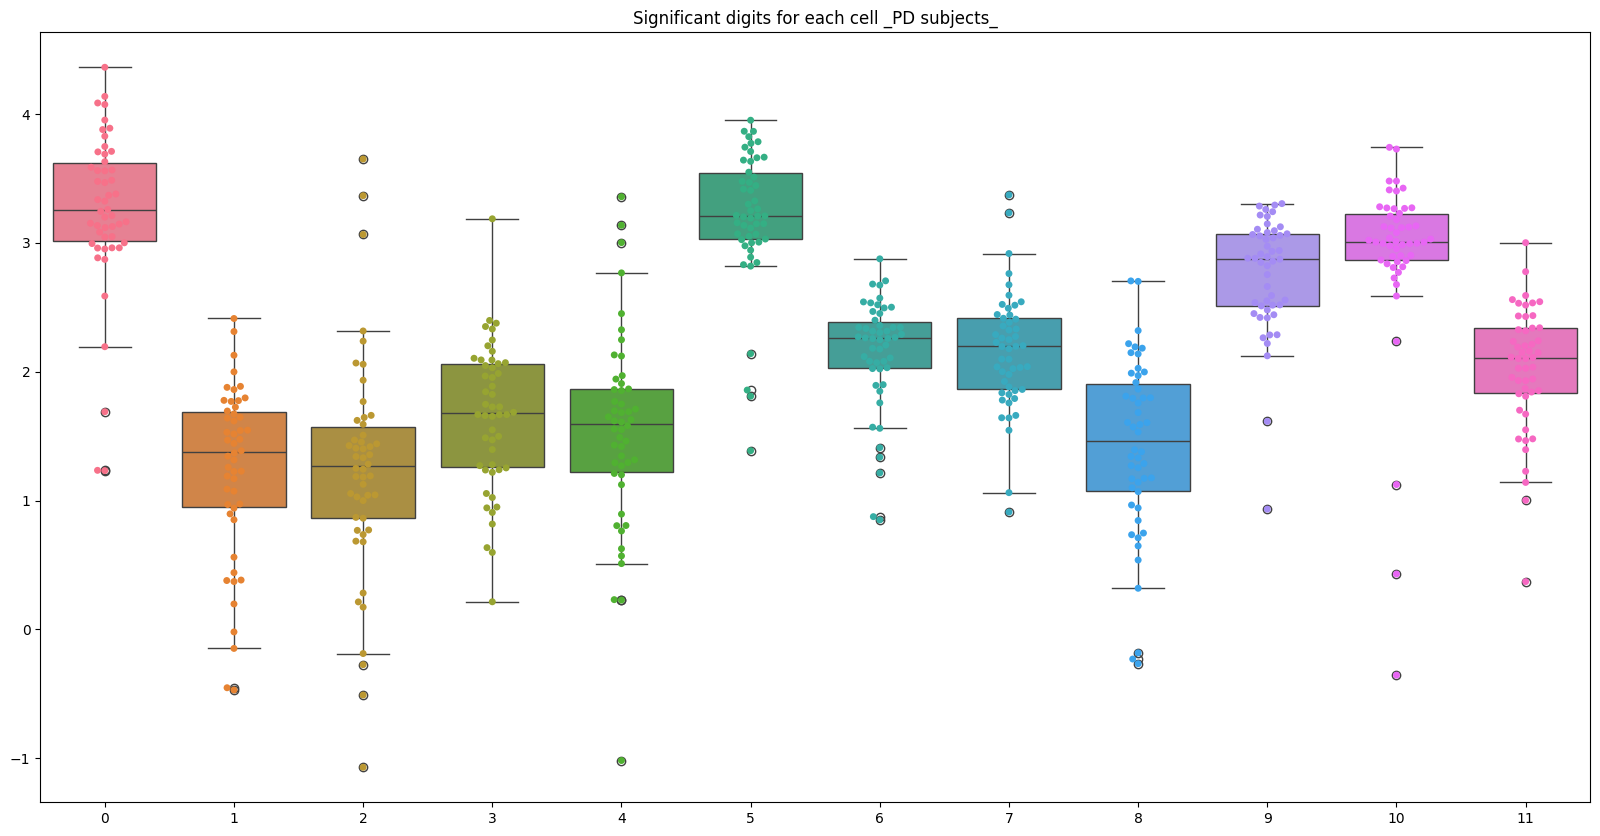

In [276]:
plt.figure(figsize=(20,10))
sns.swarmplot(cell_significant_digits_PD[:,:3,:].reshape(50,12))
sns.boxplot(cell_significant_digits_PD[:,:3,:].reshape(50,12))
plt.title('Significant digits for each cell _PD subjects_')

Text(0.5, 1.0, 'Significant digits for each cell _HC subjects_')

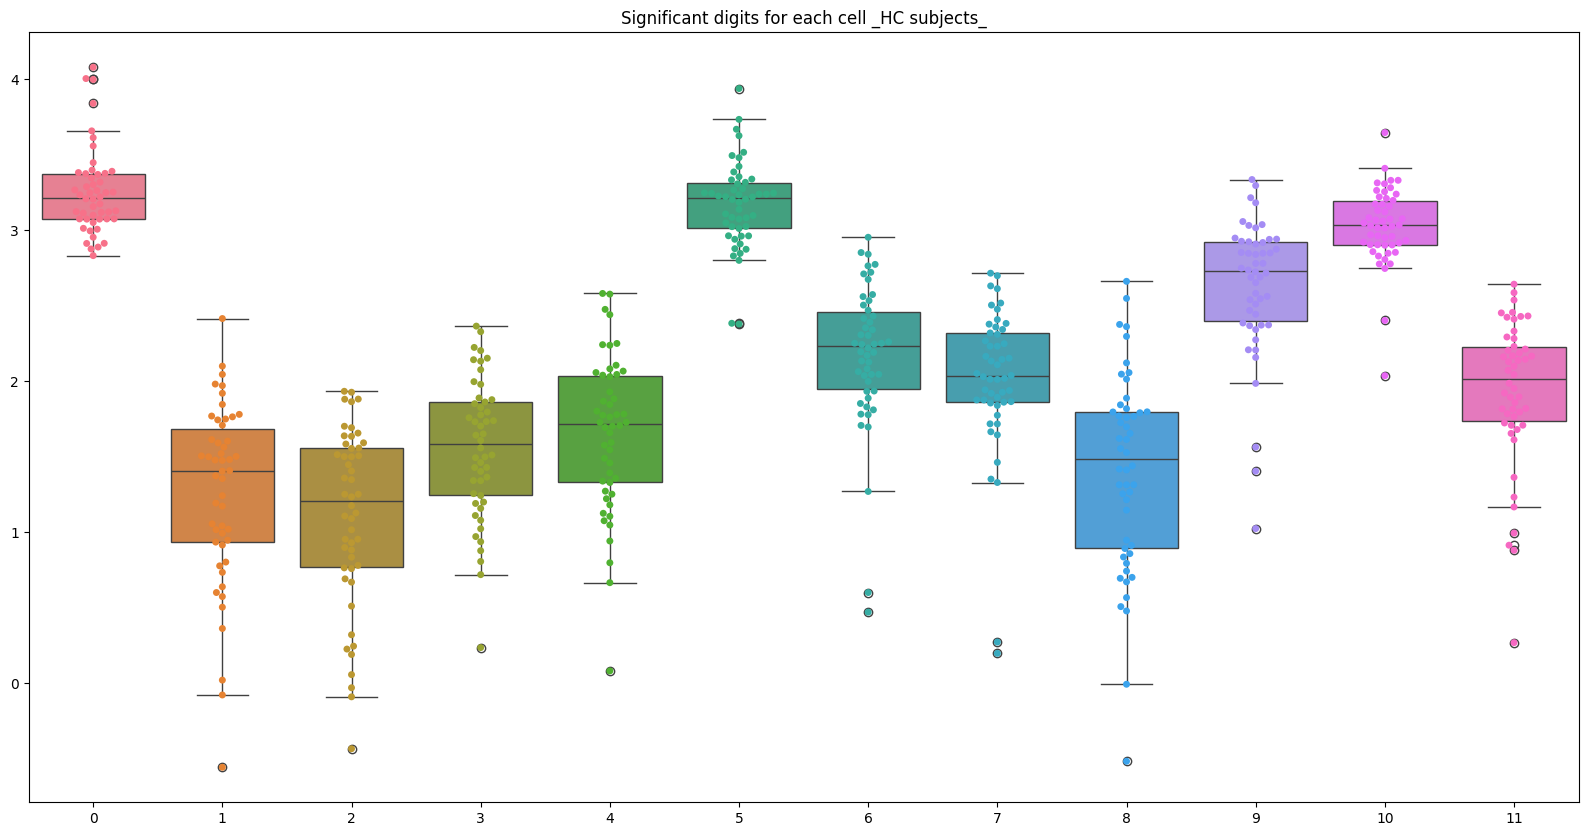

In [277]:
plt.figure(figsize=(20,10))
sns.swarmplot(cell_significant_digits_HC[:,:3,:].reshape(50,12))
sns.boxplot(cell_significant_digits_HC[:,:3,:].reshape(50,12))
plt.title('Significant digits for each cell _HC subjects_')

In [278]:
scales, translation, rotation, shears = affine.decompose(mat_dic_PD['sub-3001_ses-BL']['ieee'], shears=True, angles=True)

In [279]:
def transformation_dictionaries_mca(mat_dic, n_mca=10):

    scales_mca_dict = {sub:np.zeros((n_mca, 3)) for sub in mat_dic.keys()}
    translation_mca_dict = {sub:np.zeros((n_mca, 3)) for sub in mat_dic.keys()}
    angels_mca_dict = {sub:np.zeros((n_mca, 3)) for sub in mat_dic.keys()}
    shears_mca_dict = {sub:np.zeros((n_mca, 3)) for sub in mat_dic.keys()}

    for sub in mat_dic.keys():
        for (i,matrix) in enumerate(mat_dic[sub]['mca']):
            scales, translations, angels, shears = affine.decompose(matrix, shears=True, angles=True)
            scales_mca_dict[sub][i] = scales
            translation_mca_dict[sub][i] = translations
            angels_mca_dict[sub][i] = np.array(angels)
            shears_mca_dict[sub][i] = shears
    return scales_mca_dict, translation_mca_dict, angels_mca_dict, shears_mca_dict

In [280]:
def transformation_arrays_ieee(mat_dic):
    n = len(mat_dic.keys())
    scales_ieee = np.zeros((n, 3))
    translations_ieee = np.zeros((n, 3))
    angels_ieee = np.zeros((n, 3))
    shears_ieee = np.zeros((n, 3))

    for i, sub in enumerate(mat_dic.keys()):
        scales_ieee[i], translations_ieee[i], angels_ieee[i], shears_ieee[i] = affine.decompose(mat_dic[sub]['ieee'], shears=True, angles=True)
      
    return scales_ieee, translations_ieee, angels_ieee, shears_ieee
    

In [281]:
# Define the positions for the boxplots
positions_pd = [1]  # Positions for PD
positions_hc = [2]  # Positions for HC


def plotter(data_PD, data_HC, title,):

    dims = 3

    for i in range(dims):

        plt.subplot(1,3,i+1)
        
        data = np.column_stack([data_PD[:,i],data_HC[:,i]])

        sns.swarmplot(data)
        sns.boxplot(data, color='white')

        plt.xticks([0,1], ['PD axis ' + str(i+1), 'HC axis '+ str(i+1)])
        if i == 1:
            plt.title(title)
    
    plt.show()

In [282]:
scales_ieee_PD, translations_ieee_PD, angels_ieee_PD, shears_ieee_PD = transformation_arrays_ieee(mat_dic_PD)

In [283]:
scales_ieee_PD, translations_ieee_HC, angels_ieee_HC, shears_ieee_HC = transformation_arrays_ieee(mat_dic_HC)

In [284]:
scales_mca_dict_PD, translation_mca_dict_PD, angles_mca_dict_PD, shears_mca_dict_PD = transformation_dictionaries_mca(mat_dic_PD)

In [285]:
scales_mca_dict_HC, translation_mca_dict_HC, angles_mca_dict_HC, shears_mca_dict_HC = transformation_dictionaries_mca(mat_dic_HC)

In [286]:
scales_mca_PD = np.stack([value for value in scales_mca_dict_PD.values()])
scales_mca_HC = np.stack([value for value in scales_mca_dict_HC.values()])

In [287]:
scales_significant_PD = np.stack([sd.significant_digits(scales_mca_PD[i,:,:], reference=np.mean(scales_mca_PD[i,:,:]), axis=0) for i in range(50)])
scales_significant_HC = np.stack([sd.significant_digits(scales_mca_HC[i,:,:], reference=np.mean(scales_mca_HC[i,:,:]), axis=0) for i in range(50)])

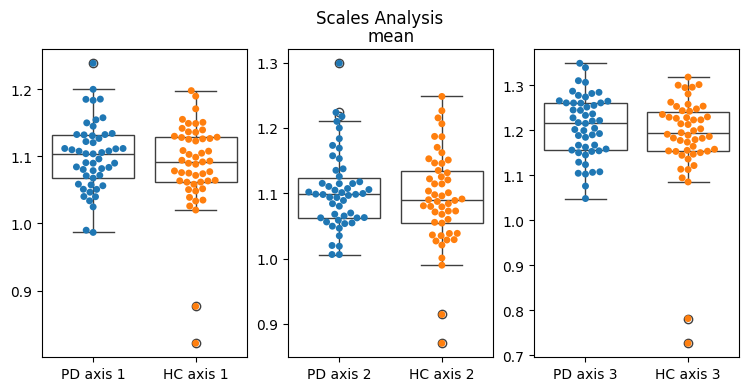

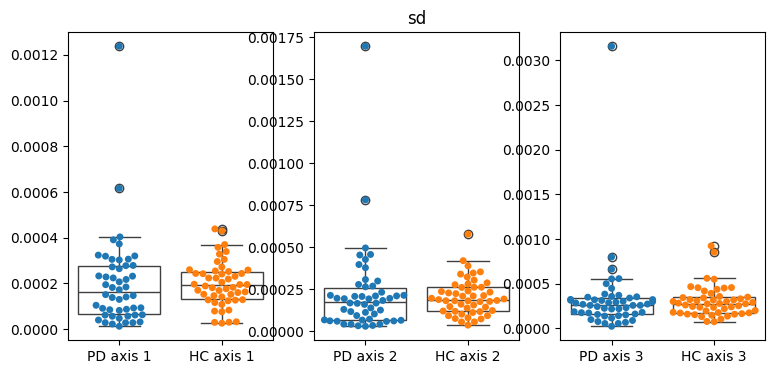

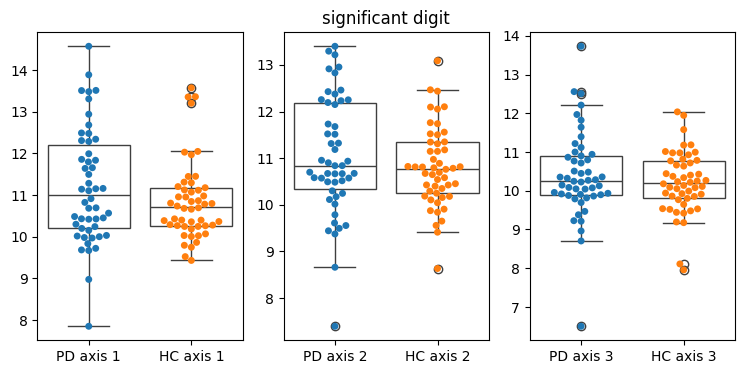

In [288]:
fig = plt.figure(figsize=(9, 4))
fig.suptitle('Scales Analysis')
plotter(np.mean(scales_mca_PD, axis=1),np.mean(scales_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(scales_mca_PD, axis=1),np.std(scales_mca_HC, axis=1), 'sd')


fig = plt.figure(figsize=(9, 4))
plotter(scales_significant_PD,scales_significant_HC, 'significant digit')



In [289]:
translations_mca_PD = np.stack([value for value in translation_mca_dict_PD.values()])
translations_mca_HC = np.stack([value for value in translation_mca_dict_HC.values()])

In [290]:
translations_significant_PD = np.stack([sd.significant_digits(translations_mca_PD[i,:,:], reference=np.mean(translations_mca_PD[i,:,:]), axis=0) for i in range(50)])
translations_significant_HC = np.stack([sd.significant_digits(translations_mca_HC[i,:,:], reference=np.mean(translations_mca_HC[i,:,:]), axis=0) for i in range(50)])

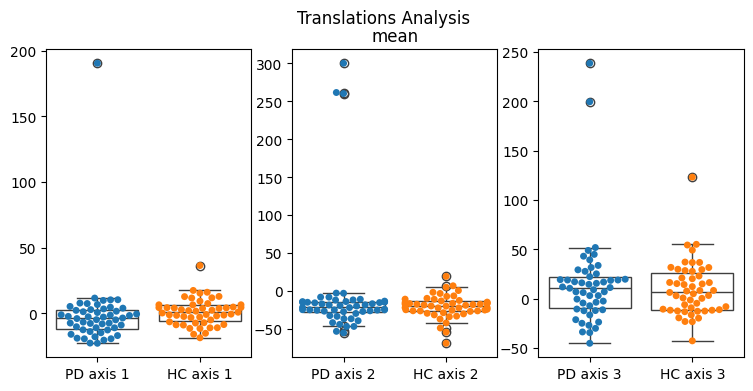

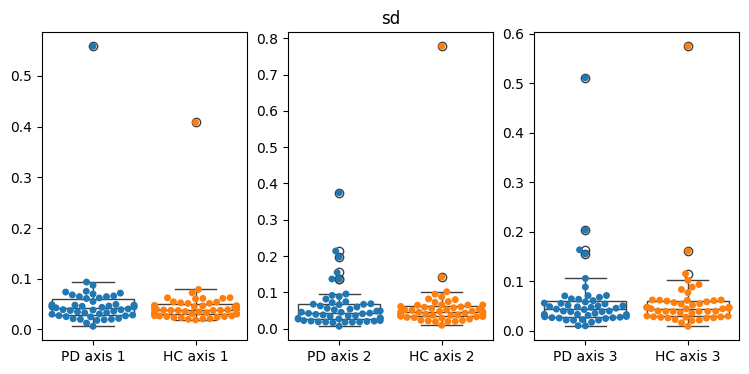

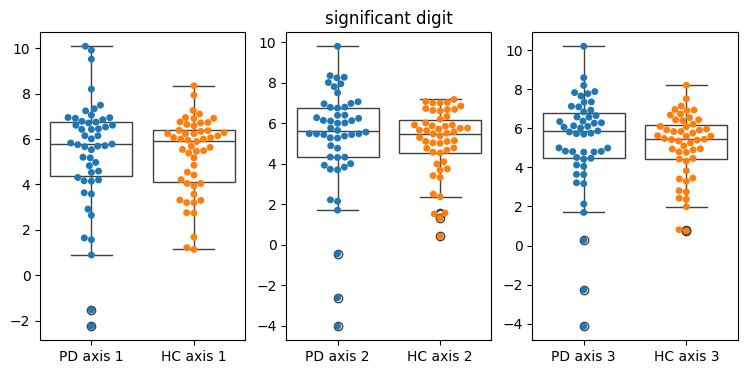

In [291]:
fig = plt.figure(figsize=(9, 4))
fig.suptitle('Translations Analysis')
plotter(np.mean(translations_mca_PD, axis=1),np.mean(translations_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(translations_mca_PD, axis=1),np.std(translations_mca_HC, axis=1), 'sd')


fig = plt.figure(figsize=(9, 4))
plotter(translations_significant_PD,translations_significant_HC, 'significant digit')



In [292]:
shears_mca_PD = np.stack([value for value in shears_mca_dict_PD.values()])
shears_mca_HC = np.stack([value for value in shears_mca_dict_HC.values()])

In [293]:
shears_significant_PD = np.stack([sd.significant_digits(shears_mca_PD[i,:,:], reference=np.mean(shears_mca_PD[i,:,:]), axis=0) for i in range(50)])
shears_significant_HC = np.stack([sd.significant_digits(shears_mca_HC[i,:,:], reference=np.mean(shears_mca_HC[i,:,:]), axis=0) for i in range(50)])

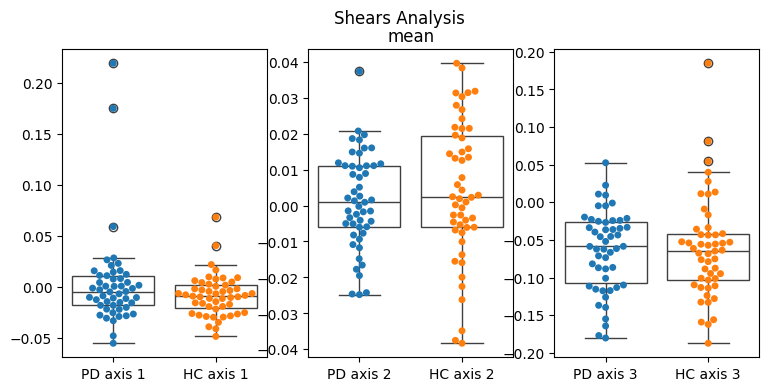

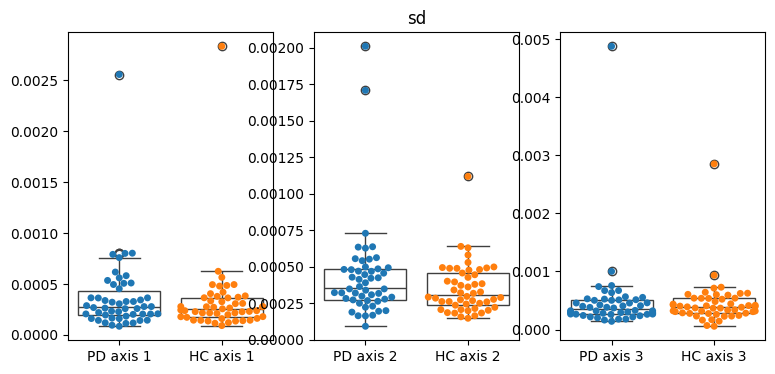

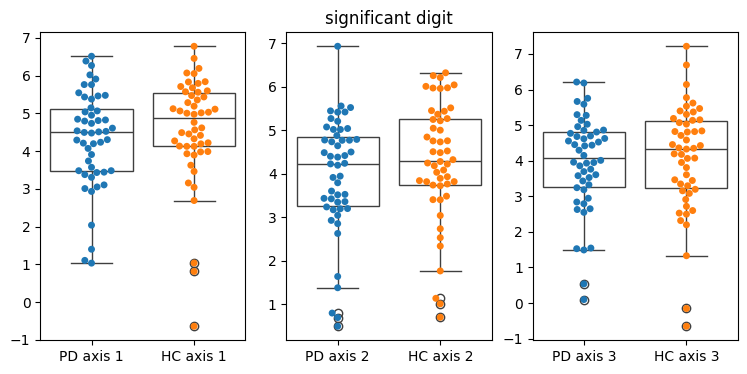

In [294]:

fig = plt.figure(figsize=(9, 4))
fig.suptitle('Shears Analysis')
plotter(np.mean(shears_mca_PD, axis=1),np.mean(shears_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(shears_mca_PD, axis=1),np.std(shears_mca_HC, axis=1), 'sd')


fig = plt.figure(figsize=(9, 4))
plotter(shears_significant_PD,shears_significant_HC, 'significant digit')


In [295]:
angles_mca_PD = np.degrees(np.stack([value for value in angles_mca_dict_PD.values()]))
angles_mca_HC = np.degrees(np.stack([value for value in angles_mca_dict_HC.values()]))

In [296]:
angles_significant_PD = np.stack([sd.significant_digits(angles_mca_PD[i,:,:], reference=np.mean(angles_mca_PD[i,:,:]), axis=0) for i in range(50)])
angles_significant_HC = np.stack([sd.significant_digits(angles_mca_HC[i,:,:], reference=np.mean(angles_mca_HC[i,:,:]), axis=0) for i in range(50)])

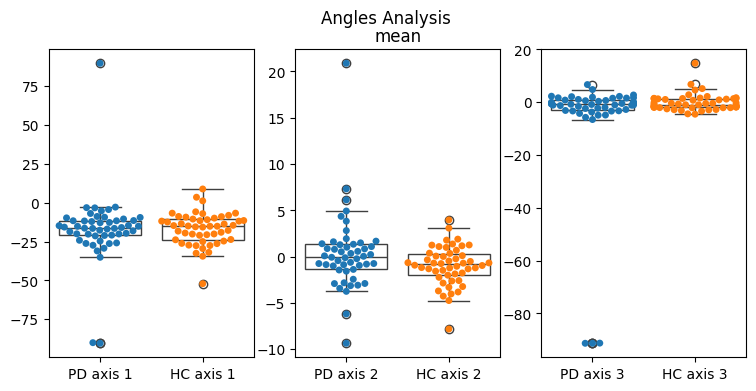

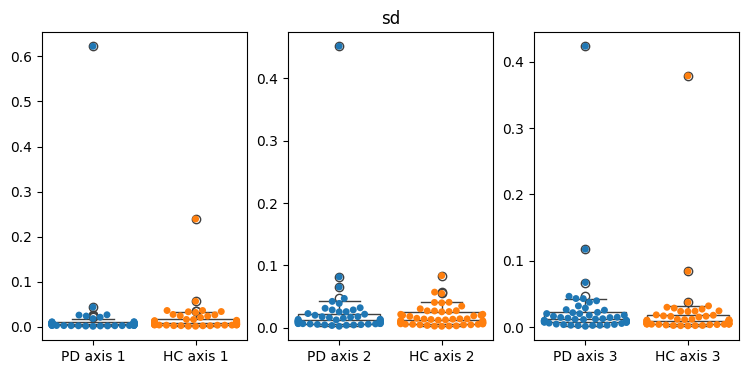

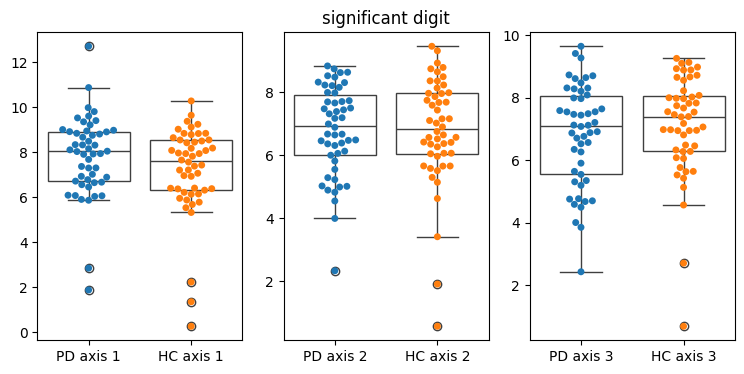

In [297]:

fig = plt.figure(figsize=(9, 4))
fig.suptitle('Angles Analysis')
plotter(np.mean(angles_mca_PD, axis=1),np.mean(angles_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(angles_mca_PD, axis=1),np.std(angles_mca_HC, axis=1), 'sd')


fig = plt.figure(figsize=(9, 4))
plotter(angles_significant_PD,angles_significant_HC, 'significant digit')


In [298]:
def leargest_indces(array, dict_, n=5):
    largest_idx = np.argsort(array, axis=0)[-n:]
    print(largest_idx.T)
    return np.array(list(dict_.keys()))[largest_idx.T]

In [299]:
angles_mca_HC_sd = np.std(angles_mca_HC, axis=1)
shears_mca_HC_sd = np.std(shears_mca_HC, axis=1)
translations_mca_HC_sd = np.std(translations_mca_HC, axis=1)
scales_mca_HC_sd = np.std(scales_mca_HC, axis=1)

In [300]:
angels_HC_largest_sd = leargest_indces(angles_mca_HC_sd,angles_mca_dict_HC)
shears_HC_largest_sd = leargest_indces(shears_mca_HC_sd,shears_mca_dict_HC)
translations_HC_largest_sd = leargest_indces(translations_mca_HC_sd,translation_mca_dict_HC)
scales_HC_largest_sd = leargest_indces(scales_mca_HC_sd,scales_mca_dict_HC)

[[45 16 48 36 33]
 [31  2 14 33 36]
 [30 11 16 36 33]]
[[26 14 16 36 33]
 [32 26 18 14 33]
 [21 30 24 27 33]]
[[12  2 26 32 33]
 [46 27 30 36 33]
 [23 14 48 36 33]]
[[29 26 15 22 30]
 [36 42 39 22 33]
 [ 6 21 25 36 33]]


In [301]:
all_HC = np.concatenate([angels_HC_largest_sd,shears_HC_largest_sd,translations_HC_largest_sd,scales_HC_largest_sd])

In [302]:
unique_elements_HC, counts_HC = np.unique(np.ravel(all_HC), return_counts=True)

In [303]:
dict(zip(unique_elements_HC,counts_HC))

{'sub-113369_ses-BL': 1,
 'sub-116230_ses-BL': 11,
 'sub-116337_ses-BL': 1,
 'sub-156484_ses-BL': 1,
 'sub-162905_ses-BL': 2,
 'sub-187823_ses-BL': 2,
 'sub-3057_ses-BL': 2,
 'sub-3104_ses-BL': 1,
 'sub-3157_ses-BL': 1,
 'sub-3171_ses-BL': 4,
 'sub-3316_ses-BL': 1,
 'sub-3369_ses-BL': 2,
 'sub-3464_ses-BL': 2,
 'sub-3527_ses-BL': 1,
 'sub-3570_ses-BL': 4,
 'sub-3620_ses-BL': 8,
 'sub-3767_ses-BL': 1,
 'sub-3807_ses-BL': 1,
 'sub-3811_ses-BL': 4,
 'sub-3812_ses-BL': 1,
 'sub-3852_ses-BL': 3,
 'sub-3853_ses-BL': 1,
 'sub-3952_ses-BL': 1,
 'sub-3969_ses-BL': 2,
 'sub-4067_ses-BL': 1,
 'sub-4079_ses-BL': 1}

In [304]:
angles_mca_PD_sd = np.std(angles_mca_PD, axis=1)
shears_mca_PD_sd = np.std(shears_mca_PD, axis=1)
translations_mca_PD_sd = np.std(translations_mca_PD, axis=1)
scales_mca_PD_sd = np.std(scales_mca_PD, axis=1)

In [305]:
angels_PD_largest_sd = leargest_indces(angles_mca_PD_sd,angles_mca_dict_PD)
shears_PD_largest_sd = leargest_indces(shears_mca_PD_sd,shears_mca_dict_PD)
translations_PD_largest_sd = leargest_indces(translations_mca_PD_sd,translation_mca_dict_PD)
scales_PD_largest_sd = leargest_indces(scales_mca_PD_sd,scales_mca_dict_PD)

[[44 30 23  8 35]
 [17 49  2 30 35]
 [10 49 46 30 35]]
[[ 2 49 17 46 35]
 [ 9 28 49 30 35]
 [10 17 28 34 35]]
[[46 42 28 30 35]
 [49 17 30  2 35]
 [ 8 30  2 17 35]]
[[46 10 25 30 35]
 [ 2 40 25 17 35]
 [25 49  3  9 35]]


In [306]:
all_PD = np.concatenate([angels_PD_largest_sd,shears_PD_largest_sd,translations_PD_largest_sd,scales_PD_largest_sd])

In [307]:
unique_elements_PD, counts_PD = np.unique(np.ravel(all_PD), return_counts=True)

In [308]:
dict(zip(unique_elements_PD,counts_PD))

{'sub-106703_ses-BL': 1,
 'sub-120403_ses-BL': 1,
 'sub-121830_ses-BL': 8,
 'sub-3120_ses-BL': 1,
 'sub-3127_ses-BL': 2,
 'sub-3279_ses-BL': 1,
 'sub-3365_ses-BL': 2,
 'sub-3403_ses-BL': 12,
 'sub-3505_ses-BL': 3,
 'sub-3700_ses-BL': 5,
 'sub-3709_ses-BL': 6,
 'sub-3777_ses-BL': 3,
 'sub-3823_ses-BL': 1,
 'sub-3960_ses-BL': 3,
 'sub-3970_ses-BL': 6,
 'sub-4121_ses-BL': 1,
 'sub-54144_ses-BL': 4}

In [309]:
#some thing like correlation but for catgorical variables

In [310]:
def jaccard_similarity(arr1, arr2):

    set1 = set(arr1)
    set2 = set(arr2)

    return len(set1.intersection(set2)) / len(set1.union(set2))


In [311]:
def frequency_vectors(arr1, arr2):

    counter1 = Counter(arr1)
    counter2 = Counter(arr2)

    all_categories = set(list(arr1)+ list(arr2))

    vector1 = [counter1[category] if category in counter1 else 0 for category in all_categories]
    vector2 = [counter2[category] if category in counter2 else 0 for category in all_categories]

    return vector1, vector2

In [312]:
def Cosine_similarity(A, B):
 
    dot_product = np.dot(A, B)

    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)

    cos_sim = dot_product / (norm_A * norm_B)
    
    return cos_sim


In [313]:
from itertools import combinations

def print_metrics(groups, all_ravel):

    a = [i for i in range(len(groups))]
    combos = list(combinations(a,2))

    for i in range(len(combos)):

        g1 , g2 = combos[i][0], combos[i][1]
        print(f"{groups[g1]} vs {groups[g2]}")

        vector1, vector2 = frequency_vectors(all_ravel[g1],all_ravel[g2])
        
        print(f"cosine similarity: {Cosine_similarity(vector1, vector2) :4f}")

        print(f"jaccard similarity: {jaccard_similarity(all_ravel[g1],all_ravel[g2]) :4f}")

        print("*********\n")


In [314]:
groups = ['angels', 'shears', 'translations', 'scales']
all_ravel_HC = [np.ravel(angels_HC_largest_sd),np.ravel(shears_HC_largest_sd),np.ravel(translations_HC_largest_sd),np.ravel(scales_HC_largest_sd)]
all_ravel_PD = [np.ravel(angels_PD_largest_sd),np.ravel(shears_PD_largest_sd),np.ravel(translations_PD_largest_sd),np.ravel(scales_PD_largest_sd)]

In [315]:
print_metrics(groups, all_ravel_HC)

angels vs shears
cosine similarity: 0.631364
jaccard similarity: 0.312500
*********

angels vs translations
cosine similarity: 0.735683
jaccard similarity: 0.375000
*********

angels vs scales
cosine similarity: 0.526787
jaccard similarity: 0.157895
*********

shears vs translations
cosine similarity: 0.750652
jaccard similarity: 0.437500
*********

shears vs scales
cosine similarity: 0.523723
jaccard similarity: 0.277778
*********

translations vs scales
cosine similarity: 0.546019
jaccard similarity: 0.200000
*********



In [316]:
print_metrics(groups, all_ravel_PD)

angels vs shears
cosine similarity: 0.750479
jaccard similarity: 0.538462
*********

angels vs translations
cosine similarity: 0.867149
jaccard similarity: 0.583333
*********

angels vs scales
cosine similarity: 0.643268
jaccard similarity: 0.500000
*********

shears vs translations
cosine similarity: 0.794996
jaccard similarity: 0.583333
*********

shears vs scales
cosine similarity: 0.666667
jaccard similarity: 0.615385
*********

translations vs scales
cosine similarity: 0.622171
jaccard similarity: 0.428571
*********



In [317]:
angles_mca_HC_mean = np.mean(angles_mca_HC, axis=1)
shears_mca_HC_mean = np.mean(shears_mca_HC, axis=1)
translations_mca_HC_mean = np.mean(translations_mca_HC, axis=1)
scales_mca_HC_mean = np.mean(scales_mca_HC, axis=1)

In [318]:
angles_mca_HC_mean.shape

(50, 3)

In [319]:
from scipy.stats import sigmaclip
a, low , upp = sigmaclip(angles_mca_HC_mean,3,3)

In [320]:
def framewise_displacement(translation, rotation, previous_translation=np.array([0,0,0]), previous_angles=np.array([0,0,0]), r=50):

    d_translation = np.sqrt(np.sum((translation-previous_translation)**2))
    d_rotation = (r*np.pi/180) * np.sqrt(np.sum((rotation-previous_angles)**2))

    return d_rotation + d_translation
     

In [321]:
#look to how vectorize it maybe
result_HC = np.zeros((50,10))
for i in range(50):
    for j in range(10):
        result_HC[i,j] = framewise_displacement(translations_mca_HC[i,j], angles_mca_HC[i,j], translations_ieee_HC[i], angels_ieee_HC[i])

In [322]:
result_PD = np.zeros((50,10))
for i in range(50):
    for j in range(10):
        result_PD[i,j] = framewise_displacement(translations_mca_PD[i,j], angles_mca_PD[i,j], translations_ieee_PD[i], angels_ieee_PD[i])

In [323]:
np.mean(result_HC, axis=1)

array([23.50550465, 21.63176274,  2.5672882 , 12.90271415, 29.97419369,
       12.33938107, 11.92141602,  8.71500312, 12.71410098, 18.19968876,
       21.5084949 , 17.84527582, 25.60899123, 13.54081301, 23.85939842,
        6.65928934, 23.83737654,  7.07074864, 28.10829943, 18.2273327 ,
        8.20523014, 16.69675011, 10.15375373, 22.59111146, 20.78941375,
       15.63412901, 17.52491586, 13.77735283,  8.26090026, 10.13324409,
       10.80370405,  9.62637223, 16.89961943,  9.22838912,  3.91885807,
       13.99209882, 47.23707226,  6.68323885,  8.20707276, 20.46158778,
        9.68039204,  7.79591757,  7.90461873, 10.34826407, 13.9328832 ,
       15.82182539, 13.31080845, 22.67889702, 27.66572458, 10.35688042])

In [324]:
np.std(result_HC, axis=1)

array([0.01956638, 0.04790552, 0.04727731, 0.03445291, 0.03748204,
       0.03159993, 0.04694301, 0.04437875, 0.06222903, 0.02409549,
       0.01984687, 0.01741456, 0.05647197, 0.03159012, 0.06880099,
       0.05749481, 0.02903729, 0.03000849, 0.05796265, 0.02735822,
       0.03389176, 0.05777006, 0.04913691, 0.11771973, 0.05043091,
       0.0650877 , 0.06957323, 0.09161944, 0.01782627, 0.05765255,
       0.08136316, 0.06529751, 0.0593159 , 0.45037586, 0.04906525,
       0.06138201, 0.1238276 , 0.05385868, 0.05262263, 0.05581426,
       0.01241662, 0.02660027, 0.06104549, 0.06379636, 0.02938538,
       0.08892176, 0.09151826, 0.02489243, 0.04717835, 0.03443944])

In [325]:
np.mean(result_PD, axis=1)

array([ 14.71429962,  10.22709586, 110.29097337,  17.37039191,
        17.98684529,  13.33463135,   2.65599316,  11.46238404,
        18.20345631,  26.8299475 ,  11.35112924,   8.30488425,
         8.50636892,  22.63691107,  11.3174545 ,  22.65923928,
        17.4207414 , 112.09840184,   6.14372195,   4.66238316,
        17.1126004 , 110.15845006,  18.20191852,  14.08300248,
        30.3053113 ,  14.66471795,  18.47684454,  10.25555484,
        10.33929491,   3.94811847,  21.16680735,  16.32252812,
        25.44674787,  13.97112518,   3.30924681,  18.46860009,
         4.38529229,  11.35656014,   9.33486143,   8.02275479,
        21.44095722,  22.50530212,  11.28834562,  13.08356662,
        15.54075083,  14.43313241,  17.14056273,  23.69946341,
        12.76681465,  14.29856432])

In [326]:
np.std(result_PD, axis=1)

array([0.05199964, 0.02753191, 0.15585484, 0.05556748, 0.0287309 ,
       0.03382418, 0.00900689, 0.03167719, 0.11031875, 0.05458304,
       0.04486447, 0.04705981, 0.03000099, 0.04536044, 0.01535414,
       0.04627592, 0.02297355, 0.15101277, 0.02791018, 0.05015855,
       0.05752163, 0.03931484, 0.02068383, 0.06690455, 0.02962752,
       0.04983758, 0.05032118, 0.0187181 , 0.07873921, 0.03579734,
       0.17859464, 0.03881097, 0.07563004, 0.03094431, 0.06271817,
       1.16599083, 0.0264003 , 0.04254587, 0.02394637, 0.04950742,
       0.07296467, 0.03741641, 0.04344778, 0.04610305, 0.06837702,
       0.01493354, 0.06405379, 0.06319711, 0.03826606, 0.10562187])